

**GAIZKIA ADELINE ATMAKA**

2501972493 LA05

NO.1 UTS SPEECH AUDIO PROCESSING

LINK VIDEO : https://www.youtube.com/playlist?list=PLgEV6IOXdLB9B6nS4YW68-9W8oyTpVG08















In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Libraries

In [2]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import torchaudio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from scipy.io import wavfile

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample

warnings.filterwarnings('ignore')

Data Preparation

In [3]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Speech Audio Processing/UTS/No1/Dataset1 dogcat audio')
!ls

cats_dogs  train_test_split.csv  utils.py


# Exploratory Data Analysis (EDA)

Melakukan plot pada signal cat and dog untuk mengetahui distribusi signal dari setiap audio (cat and dog) dan melakukan plot waveform untuk mengetahui perbedaan signal frequency pada audio cat and dog

In [4]:
signal_1, sr1 = torchaudio.load(f'./cats_dogs/train/cat/cat_1.wav')
signal_2, sr2 = torchaudio.load(f'./cats_dogs/train/dog/dog_barking_1.wav')
sr1, sr2

(16000, 16000)

Contoh Sample Audio

In [5]:
ipd.Audio('./cats_dogs/train/cat/cat_1.wav')

In [6]:
ipd.Audio('./cats_dogs/train/dog/dog_barking_1.wav')

Karena datanya masih berbentuk `.wav`, disini saya masukkan dalam 1 variable untuk mempermudah analisa data

In [7]:
def load_files(directory):
    sounds = []
    for filename in os.listdir(directory):
        if filename.endswith(".wav"):
            sample_rate, data = wavfile.read(os.path.join(directory, filename))
            sounds.append(data)
    return sounds

In [8]:
cats_sounds = load_files('./cats_dogs/train/cat/')
dogs_sounds = load_files('./cats_dogs/train/dog/')

In [9]:
len(cats_sounds), len(dogs_sounds)

(125, 85)

Jumlah / length dari audio data cat and dog

In [10]:
cats_sounds_len = [len(array) for array in cats_sounds]
dogs_sounds_len = [len(array) for array in dogs_sounds]

Signal distribution

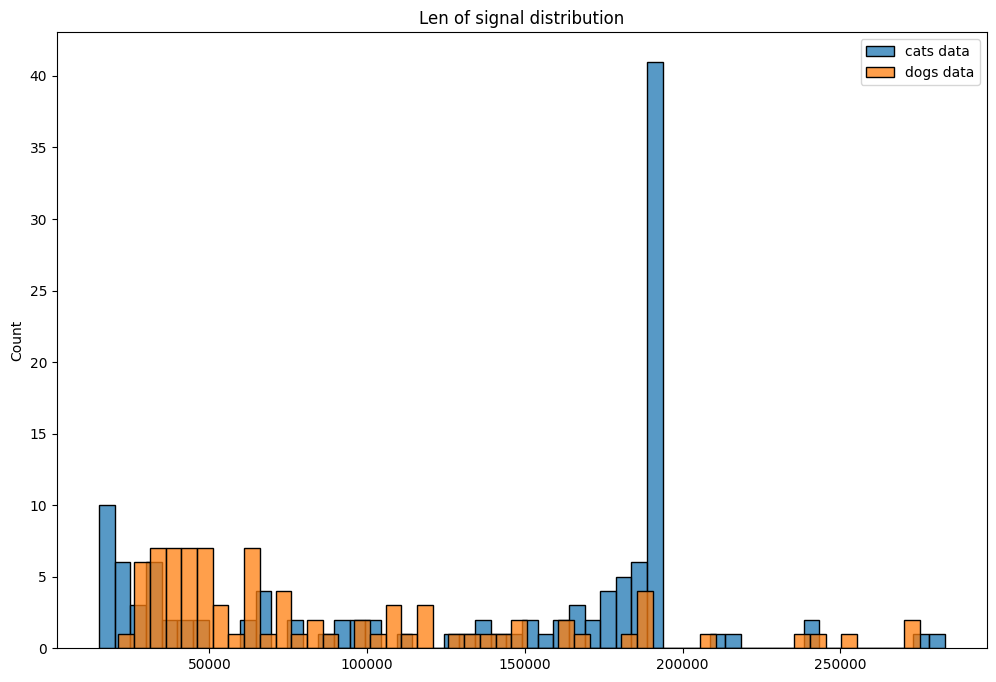

In [11]:
plt.figure(figsize = (12, 8))
sns.histplot(data = cats_sounds_len, binwidth = 5000, color = 'tab:blue')
sns.histplot(data = dogs_sounds_len, binwidth = 5000, color = 'tab:orange')
plt.legend(['cats data', 'dogs data'])
plt.title('Len of signal distribution')
plt.show()

Dari distribusi diatas, terlihat bahwa data audio untuk cat cenderung memiliki panjang sinyal yang lebih panjang, dengan banyak sampel yang memiliki panjang di atas 150.000 sampel, dengan puncaknya di sekitar 200.000 sampel. Sebaliknya, data dog memiliki distribusi panjang yang lebih merata dan jarang mencapai panjang sinyal setinggi data cat.

Wavesform Plot, untuk mengetahui bagaimana pergerakan suara cat and dog

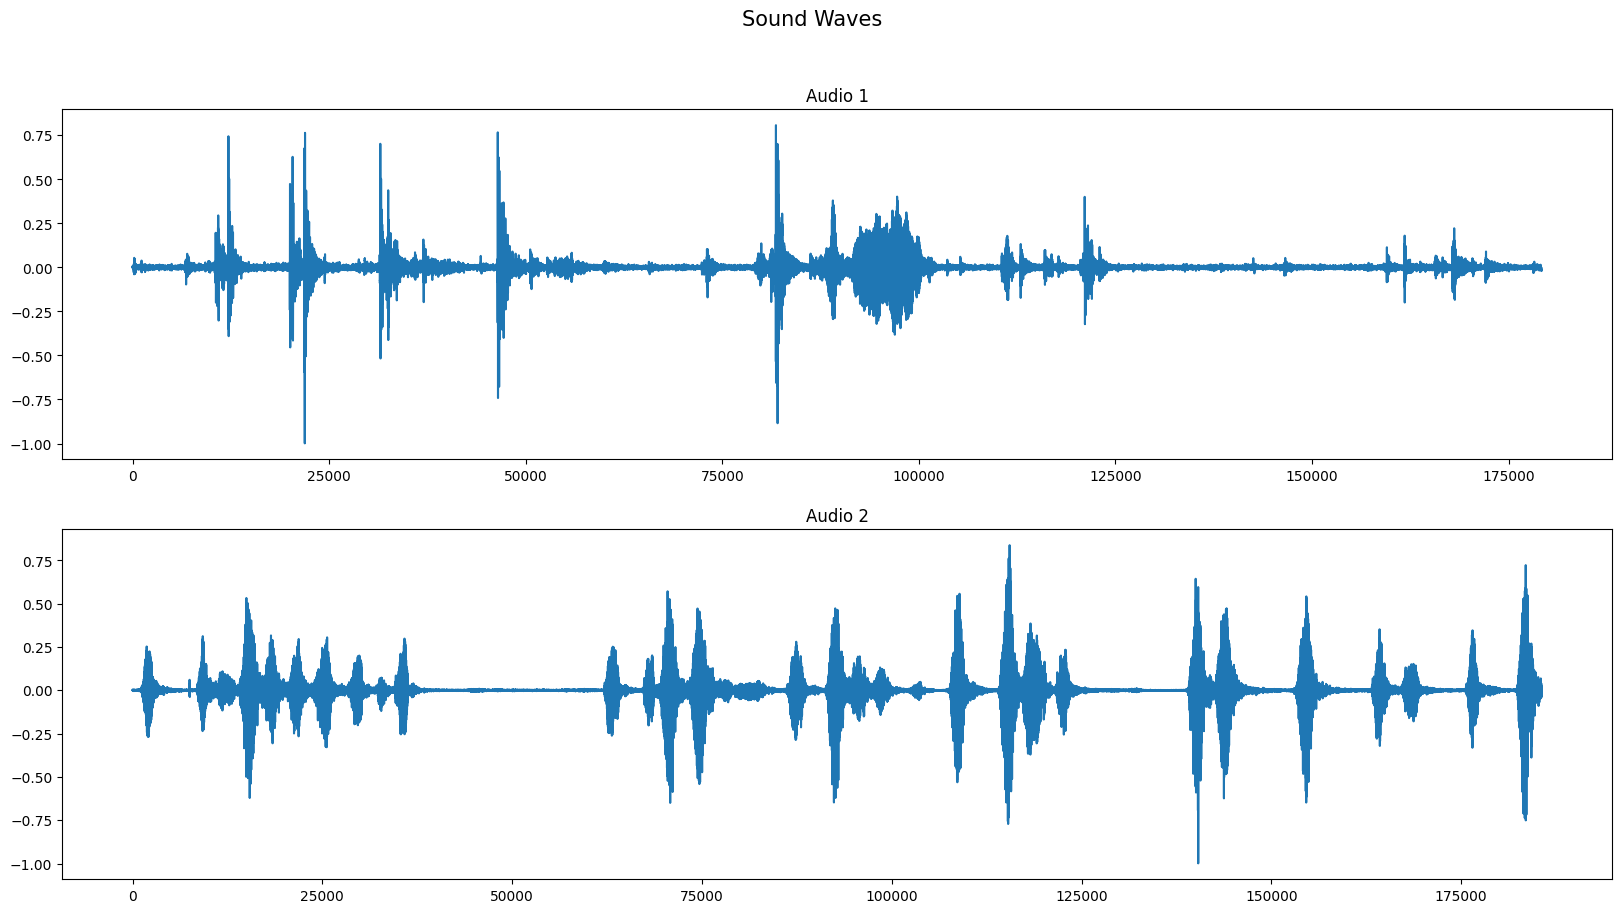

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
fig.suptitle("Sound Waves", fontsize=15)

signal_1, sr = torchaudio.load(f'./cats_dogs/train/cat/cat_1.wav')

sns.lineplot(x = np.arange(len(signal_1[0,:].detach().numpy())), y = signal_1[0,:].detach().numpy(), ax = ax[0])
ax[0].set_title("Audio 1")

signal_2, sr = torchaudio.load(f'./cats_dogs/train/dog/dog_barking_1.wav')
sns.lineplot(x = np.arange(len(signal_2[0,:].detach().numpy())), y = signal_2[0,:].detach().numpy(), ax = ax[1])
ax[1].set_title("Audio 2")

plt.show()

Kedua plot menampilkan sinyal audio dalam domain waktu, yang berarti kita bisa melihat bagaimana amplitudo suara berfluktuasi selama durasi rekaman.

Pola yang bisa ditangkap dari plot ini, yaitu:

**Perbedaan Pola Gelombang Suara**


*   Audio 1 (Cat sound): Sinyal audio menunjukkan pola suara yang lebih terpisah dan memiliki jeda di antara setiap suara. Ini menunjukkan bahwa suara kucing yang memiliki jeda atau interval tiap kali dia meongeong.
*   Audio 2 (Dog sound): Sinyal audio menunjukkan pola yang lebih sering berulang dengan amplitudo yang mirip. Ini bisa menjadi indikasi suara gonggongan yang lebih teratur dan intensitas suara yang cenderung serupa.


**Amplitudo Sinyal**

Kedua audio memiliki variasi amplitudo yang besar, yang menunjukkan fluktuasi intensitas suara. Suara dog tampak memiliki amplitudo yang lebih tinggi di beberapa bagian, menandakan suara dog yang mungkin lebih keras atau lebih kuat dibandingkan suara kucing.

# Feature Extraction

Melakukan feature extraction menggunakan MFCC (Mel-Frequency Cepstral Coefficients) sangat populer dalam pemrosesan suara atau sinyal audio, seperti voice recognition, speech recognition, dan pemrosesan sinyal audio lainnya. MFCC digunakan dalam ekstraksi fitur audio karena dapat meniru cara pendengaran manusia, mengurangi dimensi data, dan efektif untuk pengenalan suara serta analisis audio. Hal tersebut dikarenakan MFCC robust terhadap noise dan distorsi lainnya yang membuat hal tersebut cocok untuk animal audio classification.

Melakukan feature extraction menggunakan beberapa teknik ekstraksi fitur dari librosa. Fitur-fitur yang diekstrak, yaitu: RMS energy (time domain), frequency domain (f0), MFCC, spectral centroid, dan spectral bandwidth.

In [13]:
def extract_features(cat_dir, dog_dir):
    cat_features, dog_features = [], []
    cat_mfcc, dog_mfcc = [], []  # Store MFCCs for visualization

    for file, label_list, mfcc_list in zip([cat_dir, dog_dir], [cat_features, dog_features], [cat_mfcc, dog_mfcc]):
        for audio_file in os.listdir(file):
            audio_path = os.path.join(file, audio_file)
            waveform, sample_rate = librosa.load(audio_path)

            # RMS energy (time domain)
            rms = np.mean(librosa.feature.rms(y=waveform))

            # Fundamental frequency
            f0 = librosa.yin(waveform, fmin=50, fmax=500).mean()

            # MFCCs
            mfccs = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13)
            mfccs_mean = np.mean(mfccs, axis=1)

            # Store MFCCs for visualization
            mfcc_list.append(mfccs)

            # Spectral centroid and bandwidth (additional features)
            spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=waveform, sr=sample_rate))
            spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=waveform, sr=sample_rate))

            # Combine all features
            features = [rms, f0, spectral_centroid, spectral_bandwidth, *mfccs_mean]
            label_list.append(features)

    return np.array(cat_features), np.array(dog_features), cat_mfcc, dog_mfcc


In [14]:
# Paths to cat and dog audio directories
cat_directory = './cats_dogs/train/cat/'
dog_directory = './cats_dogs/train/dog/'

In [15]:
cat_features, dog_features, cat_mfcc, dog_mfcc = extract_features(cat_directory, dog_directory)

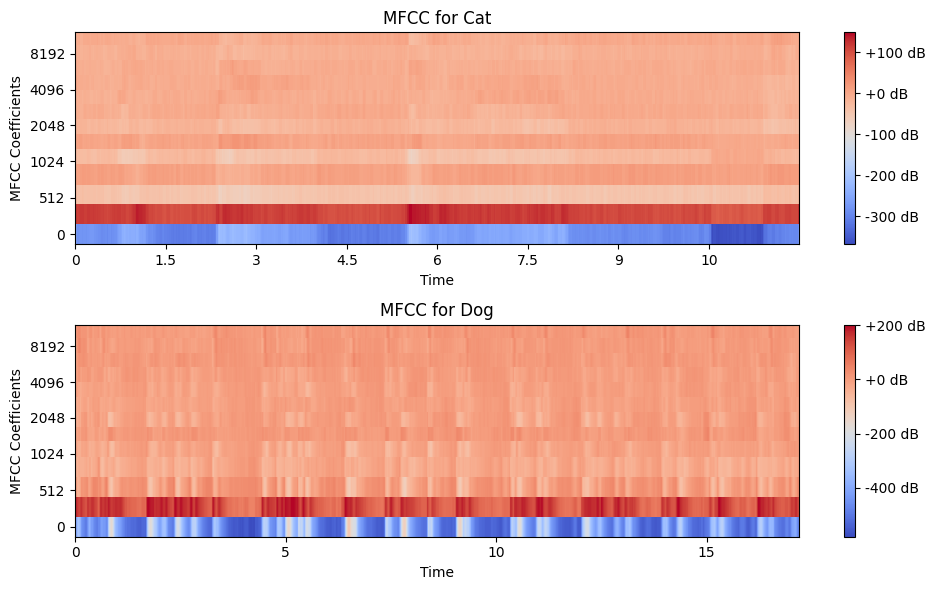

In [16]:
# Visualization of MFCC for example cat and dog audio
plt.figure(figsize=(10, 6))

# Plot MFCC for cat audio
plt.subplot(2, 1, 1)
plt.title('MFCC for Cat')
librosa.display.specshow(cat_mfcc[0], x_axis='time', sr=22050, y_axis='mel')
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")

# Plot MFCC for dog audio
plt.subplot(2, 1, 2)
plt.title('MFCC for Dog')
librosa.display.specshow(dog_mfcc[0], x_axis='time', sr=22050, y_axis='mel')
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")

plt.tight_layout()
plt.show()

In [17]:
# Calculate and print feature statistics for comparison
cat_rms_mean = cat_features[:, 0].mean()
dog_rms_mean = dog_features[:, 0].mean()
cat_f0_mean = cat_features[:, 1].mean()
dog_f0_mean = dog_features[:, 1].mean()

print(f"Average RMS (Cat): {cat_rms_mean:.2f}, Average RMS (Dog): {dog_rms_mean:.2f}")
print(f"Average Fundamental Frequency f0 (Cat): {cat_f0_mean:.2f}, Average f0 (Dog): {dog_f0_mean:.2f}")

Average RMS (Cat): 0.08, Average RMS (Dog): 0.10
Average Fundamental Frequency f0 (Cat): 211.82, Average f0 (Dog): 247.27


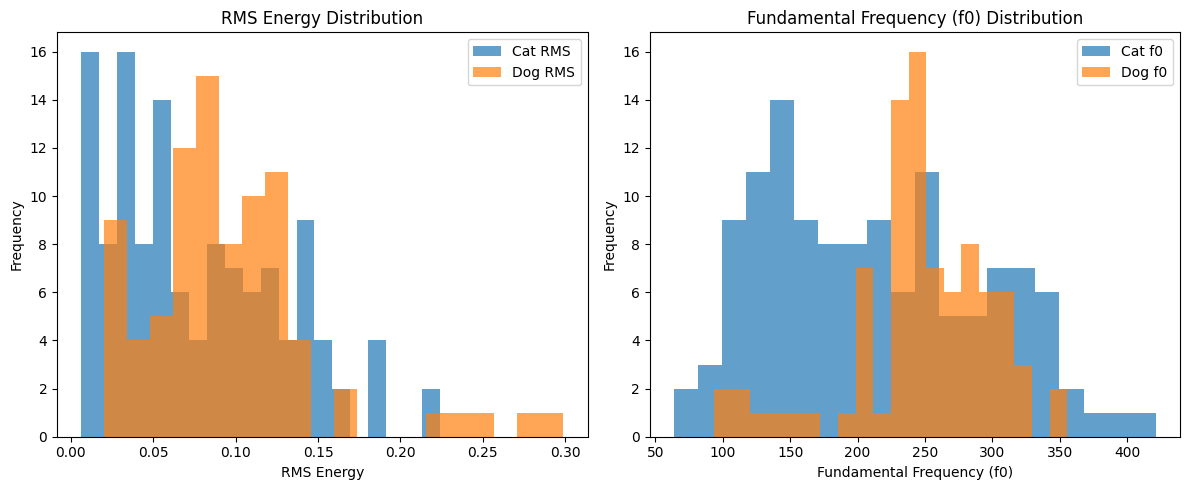

In [18]:
# Plot distribution of RMS and f0 for cats and dogs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(cat_features[:, 0], bins=20, alpha=0.7, label='Cat RMS')
plt.hist(dog_features[:, 0], bins=20, alpha=0.7, label='Dog RMS')
plt.xlabel('RMS Energy')
plt.ylabel('Frequency')
plt.legend()
plt.title('RMS Energy Distribution')

plt.subplot(1, 2, 2)
plt.hist(cat_features[:, 1], bins=20, alpha=0.7, label='Cat f0')
plt.hist(dog_features[:, 1], bins=20, alpha=0.7, label='Dog f0')
plt.xlabel('Fundamental Frequency (f0)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Fundamental Frequency (f0) Distribution')

plt.tight_layout()
plt.show()



# Analisis Fitur
1. **RMS (Root Mean Square)**:
   - **Average RMS (Cat): 0.08**, **Average RMS (Dog): 0.10**
   - **Interpretasi**: RMS merupakan ukuran intensitas atau kekuatan sinyal suara. Nilai RMS yang lebih tinggi menunjukkan suara dengan intensitas yang lebih besar.
   - Suara dog memiliki RMS rata-rata yang sedikit lebih tinggi dibandingkan suara cat. Ini menunjukkan bahwa, secara umum, suara dog mungkin cenderung lebih keras atau memiliki intensitas yang lebih besar dibandingkan suara cat.

2. **Fundamental Frequency (f0)**:
   - **Average f0 (Cat): 211.82 Hz**, **Average f0 (Dog): 247.27 Hz**
   - **Interpretasi**: Fundamental frequency adalah frekuensi dasar dari sinyal suara dan sering kali dikaitkan dengan pitch (nada) dari suara. Nilai f0 yang lebih tinggi menunjukkan pitch yang lebih tinggi.
   - Suara dog memiliki rata-rata f0 yang lebih tinggi daripada suara cat, yang menunjukkan bahwa suara anjing cenderung memiliki pitch yang lebih tinggi dibandingkan suara kucing.

### Memilih Fitur yang Paling Menjanjikan
**Fitur yang paling menjanjikan untuk membedakan suara kucing dan anjing adalah fundamental frequency (f0)**. Karena:

- Pitch (f0) menunjukkan perbedaan yang lebih signifikan antara suara cat dan dog dibandingkan RMS. Nilai rata-rata f0 untuk dog lebih tinggi, yang mungkin mencerminkan pola suara dog yang berbeda secara mendasar dari suara cat.
- Pitch merupakan karakteristik yang membedakan suara hewan karena terkait langsung dengan cara hewan tersebut menghasilkan suara. Anjing biasanya memiliki nada yang lebih tinggi dalam suara mereka, terutama saat menggonggong, sementara kucing mungkin memiliki pitch yang sedikit lebih rendah dan bervariasi ketika mengeong.
- RMS dapat bervariasi tergantung pada kondisi lingkungan atau volume rekaman, sehingga cenderung lebih tidak konsisten sebagai pembeda utama antara dua jenis suara. Walaupun RMS dapat membantu membedakan suara, fitur ini mungkin kurang andal sebagai pembeda utama dibandingkan f0.

Melakukan downsampling agar jumlah data antara dua kelas (cat and dog) menjadi seimbang. Tujuannya adalah untuk mengatasi masalah ketidakseimbangan kelas dalam dataset, yang dapat memengaruhi performa model. Setelah itu saya memberikan label 0 sebagai cat dan 1 sebagai dog

In [19]:
# Downsampling to balance classes
target_size = min(len(cat_features), len(dog_features))
cat_features_downsampled = resample(cat_features, n_samples=target_size, random_state=42)
X = np.vstack((cat_features_downsampled, dog_features))
y = np.array([0] * len(cat_features_downsampled) + [1] * len(dog_features))

In [20]:
print("Shape of X after downsampling:", X.shape)
print("Shape of y:", y.shape)

Shape of X after downsampling: (170, 17)
Shape of y: (170,)


In [21]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Modeling

Random Forest

In [27]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model using the training data
rf_model.fit(X_train, y_train)

# Make predictions using the Random Forest model on the test data
rf_predictions = rf_model.predict(X_test)

# Create a classification report
rf_report = classification_report(y_test, rf_predictions, zero_division=1)
print(rf_report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       1.00      0.92      0.96        13

    accuracy                           0.97        34
   macro avg       0.98      0.96      0.97        34
weighted avg       0.97      0.97      0.97        34



*   Model Random Forest menunjukkan performa yang sangat baik dalam mengenali kedua kelas (cat dan dog) dengan akurasi 97%.
*   Precision dan recall untuk kelas cat sangat tinggi (kedua nilai mendekati 1.00), yang menunjukkan bahwa model sangat baik dalam memprediksi kelas 0.
Precision dan recall untuk kelas dog juga cukup baik, meskipun recall untuk kelas 1 sedikit lebih rendah (0.92), yang berarti ada sekitar 8% data kelas dog yang salah diprediksi.
*   F1-score untuk kedua kelas menunjukkan keseimbangan yang sangat baik antara precision dan recall.
*   Macro avg dan weighted avg menunjukkan hasil yang sangat baik, dengan model cenderung memberikan performa yang adil dan tidak bias.

Secara keseluruhan, model ini dapat dikatakan sangat efisien dan efektif dalam tugas klasifikasi antara kucing dan anjing berdasarkan fitur yang diekstraksi.



Decision Tree

In [23]:
dt_model = DecisionTreeClassifier(random_state = 42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

dt_report = classification_report(y_test, dt_predictions)
print(dt_report)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        21
           1       0.85      0.85      0.85        13

    accuracy                           0.88        34
   macro avg       0.88      0.88      0.88        34
weighted avg       0.88      0.88      0.88        34



*   Model Decision Tree memiliki akurasi yang cukup baik, yaitu 88%, yang berarti model memprediksi dengan benar sekitar 88% dari total data uji.
*   Model ini memiliki nilai precision dan recall yang relatif seimbang untuk kedua kelas, dengan nilai tertinggi pada kelas cat (0.90) dan sedikit lebih rendah pada kelas dog (0.85).
*   F1-Score untuk kelas cat adalah 0.90 dan untuk kelas dog adalah 0.85. Meskipun ada sedikit penurunan, model tetap menunjukkan kinerja yang baik dalam menjaga keseimbangan antara precision dan recall untuk kedua kelas.
*   Baik macro average dan weighted average menunjukkan nilai yang konsisten (0.88), yang berarti model ini memiliki kinerja yang relatif baik.

Secara keseluruhan, model ini dapat dikatakan cukup baik dalam tugas klasifikasi antara kucing dan anjing berdasarkan fitur yang diekstraksi

# Hyperparameter Tuning

Penentuan hyperparameter yang digunakan didasarkan pada cara decision tree bekerja dan untuk mengoptimalkan kinerja model sambil menghindari overfitting.

a. criterion: ['gini', 'entropy']
Alasan: criterion mengontrol bagaimana kualitas split setiap node dihitung.
Gini impurity cenderung lebih cepat dalam komputasi dan biasanya digunakan dalam banyak aplikasi klasifikasi.
Entropy lebih sensitif terhadap distribusi kelas dan cenderung lebih stabil pada data yang tidak seimbang.

b. splitter: ['best', 'random']
Alasan: splitter mengontrol bagaimana split dilakukan di setiap node

c. max_depth: [None, 2, 4, 6, 8, 10, 20, 30, 40]
Alasan: max_depth mengontrol ukuran decision tree. Tree yang terlalu dalam dapat menyebabkan overfitting, sementara tree yang terlalu dangkal dapat menyebabkan underfitting.

d. min_samples_split: [1, 2, 5, 10]
Alasan: min_samples_split menentukan jumlah sampel minimum yang dibutuhkan untuk membagi suatu node. Nilai yang lebih tinggi mencegah pembagian yang terlalu kecil, yang membantu menghindari overfitting.
Memilih nilai yang lebih tinggi untuk parameter ini akan membatasi jumlah split dan regularisasi untuk mencegah split yang tidak perlu.

e. min_samples_leaf: [1, 2, 4]
Alasan: min_samples_leaf menentukan jumlah minimum sampel yang harus ada di setiap leaf tree. Ini adalah bentuk regularisasi untuk mencegah pembentukan leaf yang sangat spesifik yang hanya berlaku untuk sedikit sampel.
Nilai yang lebih besar memastikan bahwa model lebih generalisasi dan menghindari split yang terlalu mendetail.

f. max_features: ['auto', 'sqrt', 'log2']
Alasan: Parameter ini mengontrol jumlah fitur yang akan dipertimbangkan untuk setiap split node
sqrt dan log2 sering digunakan untuk meningkatkan generalisasi dan menghindari overfitting dengan membatasi jumlah fitur yang dipertimbangkan pada setiap split.

In [24]:
# Decision Tree Model with Hyperparameter Tuning
dt_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 4, 6, 8, 10, 20, 30, 40],
    'min_samples_split': [1, 2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
dt_model_hyper2 = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt_model_hyper2, dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)

# Evaluation
dt_best_model = dt_grid.best_estimator_
dt_predictions = dt_best_model.predict(X_test)
print("Best Decision Tree Hyperparameters:", dt_grid.best_params_)
print("Best Decision Tree Hyperparameters Estimator:", dt_grid.best_estimator_)
print("Decision Tree Classification Report:\n", classification_report(y_test, dt_predictions))

Best Decision Tree Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best Decision Tree Hyperparameters Estimator: DecisionTreeClassifier(max_features='sqrt', random_state=42)
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.93      1.00      0.96        13

    accuracy                           0.97        34
   macro avg       0.96      0.98      0.97        34
weighted avg       0.97      0.97      0.97        34



*   Model Decision Tree dengan best hyperparameter yang ditemukan melalui GridSearchCV memiliki performa yang sangat baik, dengan akurasi 97%.
*   Model bekerja sangat baik untuk kedua kelas (kucing dan anjing) dengan precision dan recall yang tinggi, terutama untuk kelas anjing (dog), yang diprediksi dengan sempurna (recall = 1.00).
*   F1-score yang tinggi untuk kedua kelas (0.98 untuk cat dan 0.96 untuk dog) menunjukkan keseimbangan yang baik antara precision dan recall.
*   Metrik macro average dan weighted average yang juga tinggi menunjukkan bahwa model ini dapat mengatasi ketidakseimbangan jumlah data dengan sangat baik, menghasilkan performa yang stabil di seluruh dataset.

Terjadi peningkatan yang signifikan jika dibandingkan sebelum melakukan Hyperparameter Tuning. Hal ini berarti Hyperparameter yang dipilih memberikan dampak signifikan.


<!-- # Analisa

Dari segi sampel suara kucing dan anjing, peningkatan hasil ini mungkin disebabkan oleh beberapa faktor berikut:

Model Sebelum Tuning:

Sebelum tuning, model mungkin mengalami kesulitan dalam mengklasifikasikan suara anjing dengan tepat (karena recall 0.85), terutama jika suara anjing terdengar mirip dengan suara latar belakang atau ada variasi dalam jenis suara anjing (misalnya, gonggongan yang berbeda atau suara anjing dalam kondisi tertentu). Precision yang lebih rendah pada kelas anjing (0.85) juga menunjukkan bahwa model lebih cenderung misklasifikasi suara anjing sebagai suara kucing.
Model Setelah Tuning:

Setelah dilakukan tuning hyperparameter, model mengalami peningkatan yang signifikan dalam mendeteksi suara anjing, dengan recall 1.00 dan precision 0.93. Ini berarti model bisa menangkap lebih banyak suara anjing yang sebelumnya mungkin terlewatkan, bahkan suara yang lebih kecil atau lebih pelan. Dengan parameter yang lebih tepat, pohon keputusan lebih mampu menangani variasi suara anjing dan kucing.
Suara kucing juga mendapat peningkatan, meskipun tidak sebesar suara anjing, dengan precision 1.00 dan recall 0.95. Ini menunjukkan bahwa model kini lebih mampu memisahkan suara kucing dengan lebih akurat, mengurangi risiko false positives (sampel suara kucing yang salah diklasifikasikan sebagai anjing).
Kesimpulan:
Hyperparameter tuning memberikan peningkatan yang signifikan dalam kinerja model Decision Tree untuk klasifikasi suara kucing dan anjing, baik dalam hal precision, recall, dan F1-score.
Model setelah tuning lebih akurat dan seimbang dalam mengklasifikasikan kedua kelas, dengan peningkatan yang lebih besar pada kelas anjing, yang sebelumnya lebih sulit dikenali dengan baik.
Secara keseluruhan, tuning hyperparameter membantu model untuk lebih mengenali dan membedakan karakteristik suara kucing dan anjing, mengarah pada kinerja yang lebih baik dalam pengenalan suara secara keseluruhan. -->

a. n_estimators
Alasan: Menyediakan berbagai pilihan jumlah pohon memungkinkan kita untuk mengeksplorasi trade-off antara kinerja model dan waktu komputasi.

b. max_depth
Alasan: Pengaturan ini memungkinkan kita untuk menemukan kedalaman yang optimal. Kedalaman yang terlalu besar bisa menyebabkan overfitting, sedangkan kedalaman yang terlalu kecil bisa menyebabkan underfitting.

c. min_samples_split
Alasan: min_samples_split menentukan jumlah sampel minimum yang dibutuhkan untuk membagi suatu node. Nilai yang lebih tinggi mencegah pembagian yang terlalu kecil, yang membantu menghindari overfitting.
Memilih nilai yang lebih tinggi untuk parameter ini akan membatasi jumlah split dan regularisasi untuk mencegah split yang tidak perlu.

d. min_samples_leaf
Alasan: min_samples_leaf menentukan jumlah minimum sampel yang harus ada di setiap leaf tree. Ini adalah bentuk regularisasi untuk mencegah pembentukan leaf yang sangat spesifik yang hanya berlaku untuk sedikit sampel.
Nilai yang lebih besar memastikan bahwa model lebih generalisasi dan menghindari split yang terlalu mendetail.

e. max_features
Alasan: Parameter ini mengontrol jumlah fitur yang akan dipertimbangkan untuk setiap split node
sqrt dan log2 sering digunakan untuk meningkatkan generalisasi dan menghindari overfitting dengan membatasi jumlah fitur yang dipertimbangkan pada setiap split.

f. criterion
Alasan: criterion menentukan bagaimana kualitas split pada setiap node dihitung.



In [26]:
# Random Forest Model with Hyperparameter Tuning
rf_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}
rf_model_hyper2 = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model_hyper2, rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)

# Evaluation
rf_best_model = rf_grid.best_estimator_
rf_predictions = rf_best_model.predict(X_test)
print("Best Random Forest Hyperparameters:", rf_grid.best_params_)
print("Best Random Forest Hyperparameters Estimator:", rf_grid.best_estimator_)
print("Random Forest Classification Report:\n", classification_report(y_test, rf_predictions, zero_division=1))

Best Random Forest Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Random Forest Hyperparameters Estimator: RandomForestClassifier(criterion='entropy', min_samples_split=5,
                       random_state=42)
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       1.00      0.92      0.96        13

    accuracy                           0.97        34
   macro avg       0.98      0.96      0.97        34
weighted avg       0.97      0.97      0.97        34





*   Akurasi tinggi (97%) menunjukkan bahwa model sangat efektif dalam membedakan suara antara anjing dan kucing.

*   Model lebih akurasi dalam mengenali suara kucing (precision dan recall kelas 0 lebih tinggi), namun akurasi untuk suara anjing juga sangat baik (precision kelas 1 adalah 1.00, recall 0.92).
*   Precision dan recall sangat seimbang, menunjukkan bahwa model memiliki sedikit bias terhadap salah satu kelas.


*   Metrik macro average dan weighted average yang juga tinggi menunjukkan bahwa model ini dapat mengatasi ketidakseimbangan jumlah data dengan sangat baik, menghasilkan performa yang stabil di seluruh dataset.

Namun hasil metrik ini tidak ada perubahan yang signifikan jika dibandingkan sebelum melakukan Hyperparameter Tuning. Hal ini bisa disebabkan Hyperparameter yang dipilih tidak memberikan dampak signifikan atau model sudah cukup kuat.


Kesimpulan:
Untuk perbandingan dari kedua model, sebelum dilakukan hyperparameter tuning, Model Random Forest terbukti bekerja dengan lebih baik untuk dataset ini. Namun, Model Random Forest dan Decision Tree sama sama memiliki akurasi 97% setelah dilakukan hyperparameter tuning.